This notebook is a trial on lyft dataset from kaggle foro projects addition and knowledege display for MS application. Treat it with care ;)

https://github.com/lyft/l5kit/blob/master/examples/agent_motion_prediction/agent_motion_prediction.ipynb

## Imports 

In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('')
from tqdm import tqdm, notebook
from torchvision.models import resnet50, resnet18, resnet34, resnet101,densenet121,densenet161,resnext50_32x4d
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset,PERCEPTION_LABELS

from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer

from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path
import os, shutil,time
from collections import Counter
import matplotlib.patches as mpatches


from matplotlib import animation, rc
from IPython.display import HTML, display

rc('animation', html='jshtml')



In [2]:
os.environ["L5KIT_DATA_FOLDER"]='../input/lyft-motion-prediction-autonomous-vehicles'
dm = LocalDataManager(None)

# cfg=load_config_data("../input/agent_motion_config.yaml")
# print(cfg)

In [3]:
cfg = {
    'format_version': 4,
    'data_path': "/kaggle/input/lyft-motion-prediction-autonomous-vehicles",
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'disable_traffic_light_faces': False,
        'model_name': "model_resnet50_output",
        'lr': 1e-3,

    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 1
    },
    
    'val_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 16,
        'shuffle': False,
        'num_workers': 2
    },

    'train_params': {
        'max_num_steps': 17000,
        'checkpoint_every_n_steps': 5000,
        'eval_every_n_steps': 10000
    }
}

In [4]:
DIR_INPUT = cfg["data_path"]

In [5]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    #valid_loss_min = checkpoint['val_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    print(checkpoint['epoch'])
    return model, optimizer,checkpoint['epoch']

## Build Model

In [6]:
import numpy as np

import torch
from torch import Tensor


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

In [7]:
class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        architecture = cfg["model_params"]["model_architecture"]
        backbone = eval(architecture)(pretrained=True, progress=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=2048, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=1024, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True)
            
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(512, out_features=self.num_preds + num_modes)

    def forward(self, x):
#         x = self.backbone(x)#.features.conv0(x)
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        x = self.logit(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [8]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds, confidences

## Get data

In [9]:
train_cfg=cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr= ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset= AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader=DataLoader(train_dataset, shuffle=train_cfg["shuffle"],
                            batch_size=train_cfg["batch_size"],
                            num_workers=train_cfg["num_workers"])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [10]:
def visualise(dataset, index, title="visualise input data target_positions with draw_tragetory"):
    data=dataset[index]
    im= data["image"].transpose(1,2,0)
    im=dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"]+data["centroid"][:2],data["world_to_image"])
    
    draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR ,
                    
                radius=0.1,
                   yaws=data["target_yaws"]
                   )
    
    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

/kaggle/usr/lib/kaggle_l5kit/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)


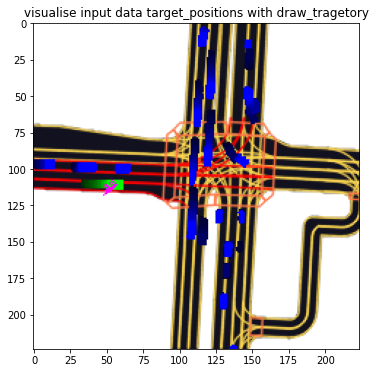

In [11]:
plt.figure(figsize= (8,6))
visualise(train_dataset, index=80)

## Training Phase

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LyftMultiModel(cfg).to(device)

optimizer = optim.Adam(model.parameters(),lr=1e-3)
# path=''
# model,optimizer,epoch=load_ckp(path, model, optimizer)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [13]:
tr_it= iter(train_dataloader)
progress_bar= tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train=[]
iterations = []
metrics = []
times = []
model_name = cfg["model_params"]["model_name"]
start=time.time()
valid_loss_min=1000
for i in progress_bar:
    
    data = next(tr_it)
    
    model.train()
    torch.set_grad_enabled(True)
    loss, _, _=forward(data, model, device)
    
    ##back pass
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    p=loss.detach().item()
    losses_train.append(p)
    progress_bar.set_description(f"loss: {p} , loss(avg): {np.mean(losses_train)}")
    writer.add_scalar('train/loss',p,i)
    checkpoint = {
            'epoch': i + 1,
            'valid_loss_min': loss.detach().item(),
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
              }
    
    if p <= valid_loss_min:
              # save checkpoint as best model
              save_ckp(checkpoint, True, f'{model_name}.pth', f'{model_name}_best.pth')
              valid_loss_min = p
                
    if i % cfg['train_params']['checkpoint_every_n_steps'] == 0:
            
            save_ckp(checkpoint, False, f'{model_name}.pth', f'{model_name}.pth')
            iterations.append(i)
            metrics.append(np.mean(losses_train))
            times.append((time.time()-start)/60)
            

results = pd.DataFrame({'iterations': iterations, 'metrics (avg)': metrics, 'elapsed_time (mins)': times})
results.to_csv(f"train_metrics_{model_name}_{num_iter}.csv", index = False)
print(f"Total training time is {(time.time()-start)/60} mins")
print(results.head())

loss: 190.51242065429688 , loss(avg): 180.5793932854428: 100%|██████████| 17000/17000 [6:36:54<00:00,  1.40s/it]   


NameError: name 'pd' is not defined

In [17]:
import pandas as pd, numpy as np
results = pd.DataFrame({'iterations': iterations, 'metrics (avg)': metrics, 'elapsed_time (mins)': times})
results.to_csv(f"train_metrics_{model_name}.csv", index = False)
print(f"Total training time is {(time.time()-start)/60} mins")
print(results.head())

Total training time is 399.0970787564913 mins
   iterations  metrics (avg)  elapsed_time (mins)
0           0   11955.738281             0.072741
1        5000     244.452334           117.728776
2       10000     206.829209           233.027299
3       15000     186.826602           348.372996


In [14]:
save_ckp(checkpoint, False, f'{model_name}_final.pth', f'{model_name}.pth')

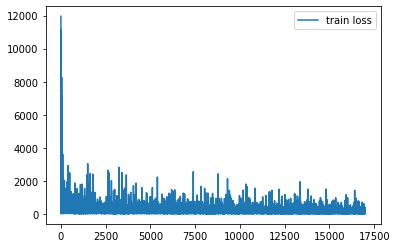

In [18]:
plt.plot(np.arange(len(losses_train)),losses_train, label="train loss")
plt.legend()
plt.show()

## Eval

In [20]:
test_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
test_mask = np.load(f"{DIR_INPUT}/scenes/mask.npz")["arr_0"]
test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)
test_dataloader = DataLoader(test_dataset,shuffle=test_cfg["shuffle"],batch_size=test_cfg["batch_size"],
                             num_workers=1)

/kaggle/usr/lib/kaggle_l5kit/ipykernel_launcher.py:5: RuntimeWarning: you're running with a custom agents_mask
  """


In [21]:

model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
confidences_list = []
agent_ids = []

progress_bar = tqdm(test_dataloader)

for data in progress_bar:

    _, preds, confidences = forward(data, model, device)

    #fix for the new environment
    preds = preds.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = []

    # convert into world coordinates and compute offsets
    for idx in range(len(preds)):
        for mode in range(3):
            preds[idx, mode, :, :] = transform_points(preds[idx, mode, :, :], world_from_agents[idx]) - centroids[idx][:2]

    future_coords_offsets_pd.append(preds.copy())
    confidences_list.append(confidences.cpu().numpy().copy())
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy()) 
    
pred_path = 'submission.csv'
write_pred_csv(pred_path,
           timestamps=np.concatenate(timestamps),
           track_ids=np.concatenate(agent_ids),
           coords=np.concatenate(future_coords_offsets_pd),
           confs = np.concatenate(confidences_list)
          )

  0%|          | 0/4446 [00:00<?, ?it/s]/kaggle/usr/lib/kaggle_l5kit/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
100%|██████████| 4446/4446 [1:34:30<00:00,  1.28s/it]


## Visualise results

In [24]:
cfg['raster_params']['disable_traffic_light_faces'] = False
cfg['test_data_loader'] = {
    'key': 'scenes/test.zarr',
    'batch_size': 128,
    'shuffle': False,
    'num_workers': 4,
}

dm = LocalDataManager()
zarr_dataset = ChunkedDataset(dm.require(cfg['test_data_loader']['key'])).open()

# Semantic view
cfg['raster_params']['map_type'] = 'py_semantic'
semantic_rasterizer = build_rasterizer(cfg, dm)

# Satellite view
cfg['raster_params']['map_type'] = 'py_satellite'
satellite_rasterizer = build_rasterizer(cfg, dm)

In [25]:
df_sub = pd.read_csv('./submission.csv')
df_sub = df_sub.set_index(['timestamp', 'track_id'])

In [26]:
def row_to_confs(row):
    return [row[f'conf_{i}'] for i in range(3)]
def row_to_coords(row):
    return row[3:].values.reshape(3, 50, 2)

In [28]:
data_path = '../input/lyft-motion-prediction-autonomous-vehicles'
semantic_dataset = EgoDataset(cfg, zarr_dataset, semantic_rasterizer)
satellite_dataset = EgoDataset(cfg, zarr_dataset, satellite_rasterizer)
test_mask = np.load(f"{data_path}/scenes/mask.npz")["arr_0"]
agent_semantic_dataset = AgentDataset(cfg, zarr_dataset, semantic_rasterizer, agents_mask=test_mask)
agent_satellite_dataset = AgentDataset(cfg, zarr_dataset, satellite_rasterizer, agents_mask=test_mask)

#Using default colors
cmap = plt.get_cmap("tab10")
matplotlib_colors_in_rgb_int = [
    [int(255 * x) for x in cmap(i)[:3]] for i in range(10)
]


/kaggle/usr/lib/kaggle_l5kit/ipykernel_launcher.py:5: RuntimeWarning: you're running with a custom agents_mask
  """
/kaggle/usr/lib/kaggle_l5kit/ipykernel_launcher.py:6: RuntimeWarning: you're running with a custom agents_mask
  


In [31]:
i_plots = np.random.randint(len(agent_semantic_dataset), size=9)

In [29]:
raster_params = cfg['raster_params']
raster_from_agent = np.array([
    [2., 0.,  56.],
    [0., 2., 112.],
    [0., 0.,   1.],
]) if (
    raster_params['raster_size'] == [224, 224] and
    raster_params['pixel_size'] == [0.5, 0.5] and
    raster_params['ego_center'] == [0.25, 0.5]
) else None
    
def generate_image_trajectory(dataset, index):
    data = dataset[index]
    im = data['image'].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    rfg = raster_from_agent if raster_from_agent is not None else data['raster_from_agent']
    target_positions_pixels = transform_points(data['target_positions'], rfg)
    draw_trajectory(im, target_positions_pixels, yaws=data['target_yaws'], rgb_color=TARGET_POINTS_COLOR)
    return im

def plot_trajectory(dataset, indices, width=12, height=4, n_cols=3, title=''):
    if not isinstance(indices, (list, np.ndarray)):
        indices = [indices]
    n_rows = len(indices) // n_cols + len(indices) % n_cols
    plt.figure(figsize=(width, height*n_rows))
    for k, index in enumerate(indices):
        plt.subplot(n_rows, n_cols, 1+k).set_title(str(index))
        im = generate_image_trajectory(dataset, index)
        plt.imshow(im, origin='lower')
    if title:
        plt.suptitle(title)
    plt.show()

def generate_image_predicted_trajectory(dataset, df_sub, index):
    data = dataset[index]
    im = data['image'].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    row = df_sub.loc[(data['timestamp'], data['track_id'])]
    # note submission coordinate system = world - centroid
    predicted_target_positions_in_sub = row_to_coords(row)
    predicted_target_positions_in_world = predicted_target_positions_in_sub + data['centroid']
    for i, coords in enumerate(predicted_target_positions_in_world):
        target_positions_pixels = transform_points(coords, data['raster_from_world'])
        draw_trajectory(im, target_positions_pixels, rgb_color=matplotlib_colors_in_rgb_int[i])
    return im, row_to_confs(row)

def plot_predicted_trajectory(dataset, df_sub, indices, width=12, height=4, n_cols=3, title=''):
    if not isinstance(indices, (list, np.ndarray)):
        indices = [indices]
    n_rows = len(indices) // n_cols + len(indices) % n_cols
    plt.figure(figsize=(width, height*n_rows))
    for k, index in enumerate(indices):
        plt.subplot(n_rows, n_cols, 1+k).set_title(str(index))
        im, confs = generate_image_predicted_trajectory(dataset, df_sub, index)
        patches = [mpatches.Patch(color=cmap(m), label='%.3f'%conf) for m, conf in enumerate(confs)]
        plt.imshow(im, origin='lower')
        plt.legend(handles=patches)
    if title:
        plt.suptitle(title)
    plt.show()

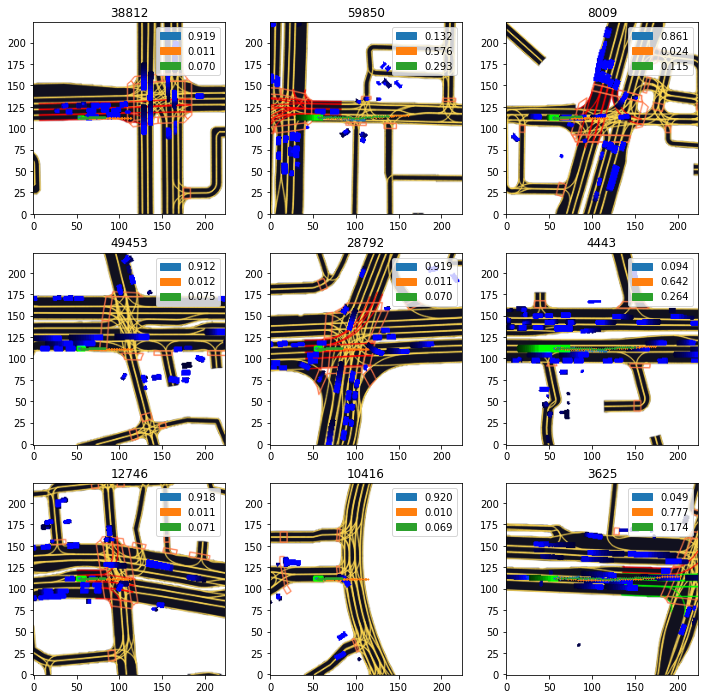

In [32]:
plot_predicted_trajectory(agent_semantic_dataset, df_sub, i_plots)

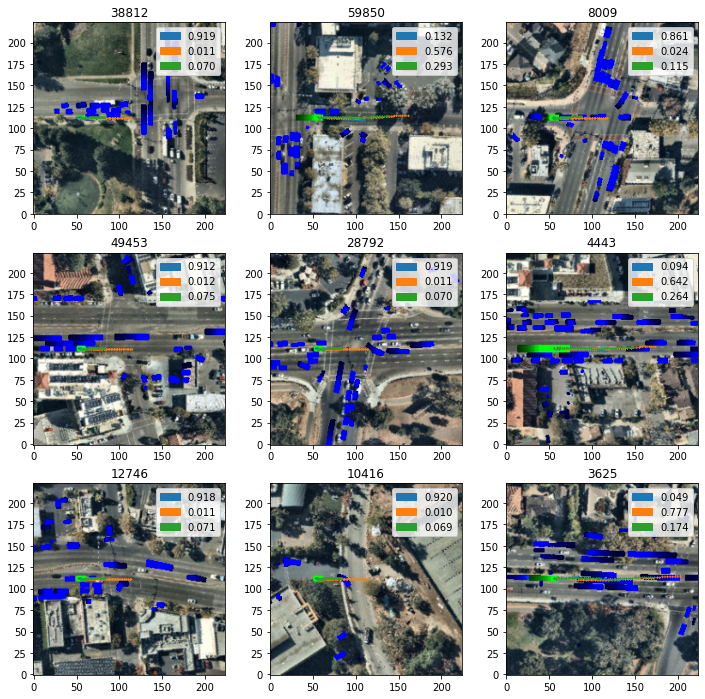

In [33]:
plot_predicted_trajectory(agent_satellite_dataset, df_sub, i_plots)

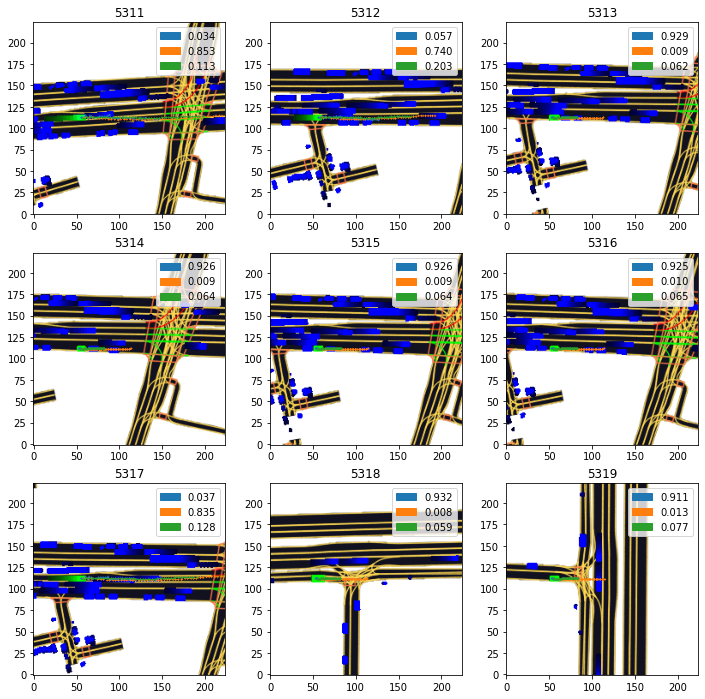

In [34]:
plot_predicted_trajectory(agent_semantic_dataset, df_sub, list(range(5311, 5311+9)))